# Matrix Factorization for Collaborative Filtering

## Introduction

The goal of a recommender system (a.k.a. recommendation system) is to predict the **rating or preference** that a **user** would give to an **item**, as commonly seen in suggestions in online services such as Netflix (movies), Spotify (music), Amazon (products), and Facebook (friends or pages).

The most common technique is called collaborative filtering (CF), which considers the existing user *behaviors* and use them as predictions without analyzing the *content* of the items (or users) themselves.

As a [motivating example](https://en.wikipedia.org/wiki/Collaborative_filtering), the following figure is a recommender system that contains existing likes or dislikes by users on different items. When predicting whether the last (query) user will like the video, the system uses a majority vote from "like-minded" users (highlighted in green) and predicts that the last user will dislike the video.

[<img src="https://upload.wikimedia.org/wikipedia/commons/5/52/Collaborative_filtering.gif" height="498" width="480" >](https://en.wikipedia.org/wiki/Collaborative_filtering)

Mathematically, we often use a user-item rating matrix $X$ to represent the data, with $n$ users as *rows* and $m$ items (or movies in this tutorial) as *columns*. Then, $x_{ij}$ and $\hat{x_{ij}}$ represent the true and predicted rating scores by user $i$ on item $j$. Therefore, the goal is to predict those unknown entries such that $\hat{x_{ij}}$ can be as close to $x_{ij}$ as possible.

Unlike traditional memory-based (a.k.a. user-based or item-based) algorithms which relies on finding the $k$ nearest neighbors, this tutorial focuses on another approach called **matrix factorization**. We will use this technique to predict movie ratings.


## Required Libraries
This tutorial requires Python 3.5+, NumPy 1.10+ (for [`@` matrix multiplication operator](https://docs.python.org/3/whatsnew/3.5.html#whatsnew-pep-465)), SciPy (for [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html) operations), and Matplotlib. (for plotting).

In [1]:
# Third-party libraries
import numpy as np
from numpy.linalg import norm
from scipy.sparse import csr_matrix, coo_matrix
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Built-in modules
from collections import Counter
import csv
from time import time
import sys

Also, for reproducible results when re-running this Jupyter Notebook, we will set a fixed NumPy random seed.

In [2]:
np.random.seed(15688)

In [3]:
# Matplotlib rcParams (It has to be in a separate cell in order to work!)
matplotlib.rcParams.update({'figure.figsize': [10, 5], 'font.size': 14})

## Dataset

The best known dataset for this task is the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) dataset, which can be downloaded from [Kaggle](https://www.kaggle.com/netflix-inc/netflix-prize-data). However, it is 2 GB of sparse matrix entries and will be too large on a single machine.

Instead, this tutorial uses a similar **[MovieLens](https://grouplens.org/datasets/movielens/)** dataset which also contains sparse user-movie rating scores. Specifically, the `ml-latest-small` dataset (2.4 MB) is much more suitable for tutorial purposes, but still requires careful sparse matrix implementation for the algorithm to run efficiently.

The MovieLens dataset can be download from https://grouplens.org/datasets/movielens/latest/.

We will only use the `ratings.csv` file in the `ml-latest-small` dataset, which contains 100004 ratings by 671 users across 9066 movies. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). All selected users had rated at least 20 movies.

For complete dataset description, visit the [README page](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) or `README.txt`.

### Reading and Pre-processing Data

First, let's read the `ratings.csv` file and produce the `data`, `row_idx`, and `col_idx` lists needed for SciPy's sparse matrix library.

The CSV line format is `userId,movieId,rating,timestamp` (timestamp is not used). However, because there are numerous "empty" movies (all-zero columns), we should re-index movie IDs (in data reading order, first movie = 0) to shrink dimensionality $m$.

In [4]:
csv_file = 'ml-latest-small/ratings.csv'
n, m = 0, 0
row_idx, col_idx, data = [], [], []
# Reindex movies by a dictionary: {read_col_ID: new_col_ID}
movie_reidx = {}

with open(csv_file, 'r') as fin:
    reader = csv.reader(fin)
    # Skip header row
    next(reader)
    for line in reader:
        user, movie, rating, _ = line
        user, movie, rating = int(user), int(movie), float(rating)
        # Make new user/movie IDs 0-indexed
        row_idx.append(user - 1)
        if movie not in movie_reidx:
            # New movie ID
            movie_reidx[movie] = m
            m += 1
        col_idx.append(movie_reidx[movie])
        data.append(rating)
        n = max(n, user)
row_idx, col_idx, data = np.array(row_idx), np.array(col_idx), np.array(data)
print('Total: %d users, %d movies, %d ratings' % (n, m, len(data)))

Total: 671 users, 9066 movies, 100004 ratings


For machine learning purposes, we will randomly permute the non-zero entries and split it into training set (60%), validation set (20%), and test set (20%).

Then, use the permutation indices to form a sparse matrix `X_train` of shape $(n, m)$ and two dense matrices `Q_valid`, `Q_test` of shape $(q, 3)$.

In [5]:
all_size = len(data)
train_size, valid_size = int(round(all_size * 0.6)), int(round(all_size * 0.2))
# Calculate test_size by subtraction to avoid rounding errors
test_size = all_size - train_size - valid_size
print('Train : Valid : Test = %d : %d : %d' % (train_size, valid_size, test_size))

# Create random permutation of [0, 1, ..., all_size-1] and split the dataset by slicing
perm_idx = np.random.permutation(np.arange(all_size))
train_idx = perm_idx[:train_size]
valid_idx = perm_idx[train_size : train_size + valid_size]
test_idx = perm_idx[train_size + valid_size:]

# Directly manipulate the data, row_idx, col_idx lists to form matrices
X_train = coo_matrix((data[train_idx], (row_idx[train_idx], col_idx[train_idx])), shape=(n, m))
Q_valid = np.array([row_idx[valid_idx], col_idx[valid_idx], data[valid_idx]]).T
Q_test = np.array([row_idx[test_idx], col_idx[test_idx], data[test_idx]]).T
print('X_train.shape: %s, Q_valid.shape: %s, Q_test.shape: %s' % (X_train.shape, Q_valid.shape, Q_test.shape))

Train : Valid : Test = 60002 : 20001 : 20001
X_train.shape: (671, 9066), Q_valid.shape: (20001, 3), Q_test.shape: (20001, 3)


### Exploratary Data Analysis

Now, let's compute and visualize some summary statistics of the *training* set to understand our data better.

For code reuse throughout this tutorial, define generic plotting functions like `bar_plot()` and `hist_plot()`.

In [6]:
def bar_plot(x, y, title, xlabel, ylabel, **kwargs):
    plt.figure()
    # Set xticks at x assuming x is numeric
    plt.xticks(x)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.bar(x, y, **kwargs)

In [7]:
def hist_plot(x, bins, title, xlabel, ylabel, **kwargs):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.hist(x, bins=bins, **kwargs)

Then, plot a bar plot (*not* a histogram) for the *discrete* rating score distribution. We will use a `Counter` for counting.

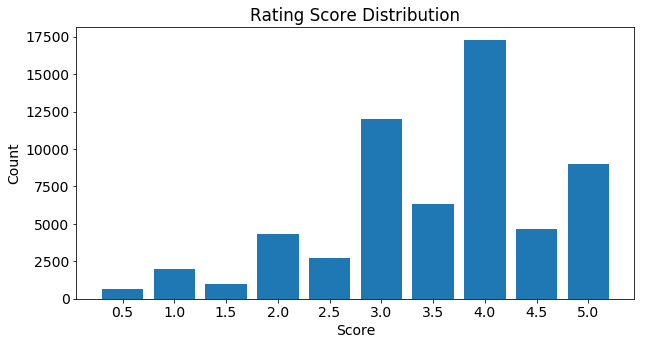

In [8]:
ratings = Counter(X_train.data)
x, y = [], []
for score in sorted(ratings.keys()):
    count = ratings[score]
    x.append(score)
    y.append(count)
bar_plot(x, y, 'Rating Score Distribution', 'Score', 'Count', width=0.4)

Also, compute the overall mean and median scores. The mean score will be used for later processing.

In [9]:
mean_score = np.asscalar(np.mean(X_train.data))
median_score = np.asscalar(np.median(X_train.data))
print('(Average, Median) score across training set: (%.2f, %.2f)' % (mean_score, median_score))

(Average, Median) score across training set: (3.54, 4.00)


We can see the mean score is 3.54, but the median score is up to 4.00, which might indicate that in a movie rating system, people tend to give high scores more frequently than low scores.

Next, let's examine the **data sparsity**. We can compute the number (percentage) of the non-zero entries, the number of unique users, and the number of unique movies in the sparse matrix.

In [10]:
print('Training non-zero entries: %d (%.3f%%) by %d users, %d movies' %
      (X_train.nnz, X_train.nnz / (n * m) * 100, len(np.unique(X_train.row)), len(np.unique(X_train.col))))

Training non-zero entries: 60002 (0.986%) by 671 users, 7607 movies


The MovieLens dataset is indeed very sparse. Only less than 1% of the matrix entries contain rating scores.

Then, plot a histogram for the distribution of the number of ratings a user gives. This can be done by counting the number of non-zero entries in rows or columns using the `getnnz()` function.

mean: 89.421759, median: 43.000000, min: 9, max: 1437


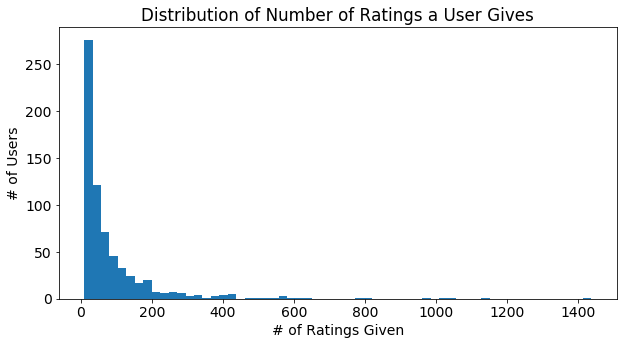

In [11]:
rows_nnz = X_train.getnnz(axis=1)
hist_plot(rows_nnz, 60, 'Distribution of Number of Ratings a User Gives', '# of Ratings Given', '# of Users')
print('mean: %f, median: %f, min: %d, max: %d'
      % (np.mean(rows_nnz), np.median(rows_nnz), np.min(rows_nnz), np.max(rows_nnz)))

We can see that even though the users are deliberately selected in this dataset (each having rated >= 20 movies), the majority of them in the *training* set still give fewer than 25 ratings. Interestingly, the most active user gives 1437 ratings.

Let's do the same thing for movies. Plot a histogram for the distribution of the number of ratings a movie receives.

mean: 6.618354, median: 2.000000, min: 0, max: 202


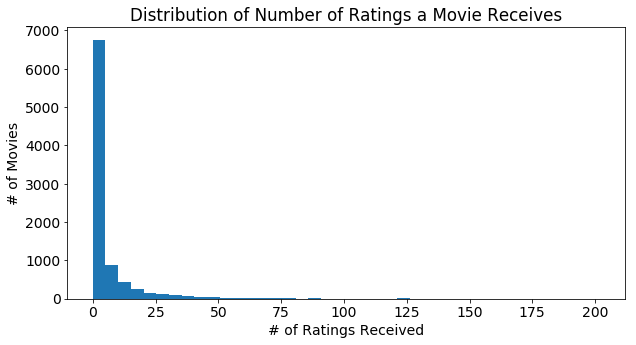

In [12]:
cols_nnz = X_train.getnnz(axis=0)
hist_plot(cols_nnz, 40, 'Distribution of Number of Ratings a Movie Receives', '# of Ratings Received', '# of Movies')
print('mean: %f, median: %f, min: %d, max: %d' 
      % (np.mean(cols_nnz), np.median(cols_nnz), np.min(cols_nnz), np.max(cols_nnz)))

The sparsity is even more severe in movies. The majority of them receive only fewer than 5 movies, with median of 2. 

Therefore, the data sparsity will create great difficulty in our rating prediction task.

Finally, use the same `rows_nnz` and `cols_nnz` variables to compute the "unseen" users or movies as boolean indicator vectors of lengths $n$ or $m$.

In [13]:
# These indicator vectors will be used at prediction time
unseen_users, unseen_movies = (rows_nnz == 0), (cols_nnz == 0)
print('%d unseen users, %d unseen movies' % (np.sum(unseen_users), np.sum(unseen_movies)))

0 unseen users, 1459 unseen movies


You can verify the calculation by that 9066 (all movies) = 7607 (training movies) + 1459 (unseen movies).

### Subtract Default Scores as Missing Value Imputation

An important part of data pre-processing is imputing **missing values** (zero entries here). You may think of filling them with some "default score" (say 3.0) or with the means/medians of rows/columns. However, this will break the *sparsity* right away and significantly slow down later algorithms.

Instead, we can *subtract* all the non-zero entries in `X_train` by this "default score" and maintain the sparsity. Just remember to add the default score back at prediction time.

This tutorial uses the `mean_score` as `default_score` as it leads to better performance.

In [14]:
# Operate on X_train.data instead of X_train
default_score = mean_score
X_train.data -= default_score
# Convert `X_train` to CSR format for faster operations later.
X_train = csr_matrix(X_train, copy=False)

## Evaluation Metrics

This tutorial uses the [root-mean-square error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) metric to evaluate the prediction with respect to the ground truth:

$$RMSE = \sqrt{\frac{1}{q}\sum_{i,j \in Q}{(\hat{x_{ij}} - x_{ij})^2}}$$

, where $Q$ is the query (validation or test) set, and $q$ is the number of queries.

Before we do any prediction, let's write a `get_RMSE()` function given two lists of predicted and true ratings.

In [15]:
# Input: 1D NumPy arrays of predicted and true ratings
# Output: scalar RMSE score
def get_RMSE(pred, truth):
    RMSE = np.asscalar(np.sqrt(np.mean(np.square(pred - truth))))
    return RMSE

Also, write a `running_time()` utility function to measure running time.

In [16]:
# Input: starting timestamp obtained by calling time.time() earlier in the code
# Output: string of running time of the form 'x.xx seconds'
def running_time(t_start):
    t_end = time()
    return '%.2f seconds' % (t_end - t_start)

# Quick testing
t_temp = time()
X_temp = np.random.rand(1500, 10000) @ np.random.rand(10000, 1000)
print(running_time(t_temp))

1.94 seconds


Again, write another utility function `prints()` to print a string without a new line during training.

In [17]:
def prints(s):
    sys.stdout.write(s)
    sys.stdout.flush()

## The Matrix Factorization (MF) Problem

The matrix factorization (MF) algorithm rely on automatically discovering **latent factors** from rating data and representing users and movies in a **latent space**. We can think of them as $d$ *unsupervised features* (e.g., movie genres) learned from data.

In the following figure from paper [[1]](#References), suppose the MF algorithm discovers $d=2$ hypothetical latent factors and represent each user $i$ (as vector $\mathbf{u_i}$) and movie $j$ (as vector $\mathbf{v_j}$) in a 2-dimensional latent space. Then, we can define the predicted rating by user $i$ on movie $j$ as their vector *similarity* in the latent space, measured by the **inner product**:

$$\hat{x_{ij}} \equiv \mathbf{u_i}^T \mathbf{v_j}$$

Therefore, we can expect "Gus to love *Dumb and Dumber*, to hate *The Color Purple*, and to rate *Braveheart* about average".


[<img src="https://i.imgur.com/24mx914.jpg" height="600" width="600">](https://dl.acm.org/citation.cfm?id=1608614)

Mathematically, with $d$ latent factors, we can formulate the problem as factorizing the user-movie rating matrix $X$ ($n \times m$) into the product of latent user matrix $U$ ($n \times d$) and latent movie matrix $V$ ($d \times m$). The users and movies are now represented in the latent space as *rows* of $U$ and *columns* of $V$, and the relationship $\hat{x_{ij}} = \mathbf{u_i}^T \mathbf{v_j}$ still holds.

Therefore, the machine learning objective becomes solving for all $\mathbf{u_i}$ and $\mathbf{v_j}$ that minimizes the loss function $L$ composed of sum-of-square errors (SSE) and two regularization terms by the squared norms of $\mathbf{u_i}$ and $\mathbf{v_j}$:

$$L = \sum_{i,j \in nnz} [\frac{1}{2}(x_{ij} - \mathbf{u_i}^T \mathbf{v_j})^2 + \frac{1}{2}\lambda_U \|\mathbf{u_i}\|^2 + \frac{1}{2}\lambda_V \|\mathbf{v_j}\|^2] $$

, where $nnz$ is the set of all indices $(i,j)$ in the non-zero entries of the training matrix.

There are several ways to solve this optimization problem. This tutorial uses stochastic gradient descent (SGD) that requires only $O(|nnz|)$ time per epoch by looping through the non-zero entries in `X_train` exactly once.

## Solving MF by Stochastic Gradient Descent (SGD)

Instead of the total loss, SGD is only based on the loss of *one* training instance (non-zero entry) $L_{ij}$:

$$L_{ij} = \frac{1}{2}(x_{ij} - \mathbf{u_i}^T \mathbf{v_j})^2 + \frac{1}{2}\lambda_U \|\mathbf{u_i}\|^2 + \frac{1}{2}\lambda_V \|\mathbf{v_j}\|^2 $$

To siimplify notation, define the error term as $e_{ij} \equiv x_{ij} - \mathbf{u_i}^T \mathbf{v_j} $. Then the gradients are:

$$\frac{\partial{L_{ij}}}{\partial{\mathbf{u_i}}} = -e_{ij} \mathbf{v_j} + \lambda_U \mathbf{u_i}$$

$$\frac{\partial{L_{ij}}}{\partial{\mathbf{v_j}}} = -e_{ij} \mathbf{u_i} + \lambda_V \mathbf{v_j}$$

Therefore, the SGD update rules will be:

$$\mathbf{u_i} \leftarrow \mathbf{u_i} + \alpha^{(t)} \cdot (e_{ij} \mathbf{v_j} - \lambda_U \mathbf{u_i})$$

$$\mathbf{v_j} \leftarrow \mathbf{v_j} + \alpha^{(t)} \cdot (e_{ij} \mathbf{u_i} - \lambda_V \mathbf{v_j})$$

, where $\alpha^{(t)}$ is the learning rate at epoch $t$.

In this tutorial, we define the initial learning rate as $\alpha^{(0)}$ and decay it per epoch by:
$$ \alpha^{(t)} = \frac{\alpha^{(0)}}{1 + (\beta - 1) t} $$

As suggested in paper [[2]](#References), the inner product $\mathbf{u_i}^T \mathbf{v_j}$ is passed through a sigmoid function to be in range [0, 1]. At training, the true rating is min-max scaled to be in range [0, 1] too for comparison. At testing, on the other hand, we should reverse-min-max scale the sigmoidal inner product back in range [0.5, 5.0].

Usually in a non-convex machine learning problem like matrix factorization, *parameter tuning* can be a time-consuming process. In this tutorial, however, the parameters are already tuned as the following values:

In [18]:
# Parameters
k = 64
lambda_U = 1e-2
lambda_V = 2e-2
T = 50
alpha_init = 1e-1
beta = 5e-2

# Other constants
min_score = 0.5
max_score = 5.0

Now we are ready to implement the SGD **training**. Writing the whole `train_MF_SGD()` in one cell can be quite long, so we separate some code into a few helper functions as explained in later cells.

Note that we cannot initialize $U$ and $V$ to all zeros in this problem because then all the gradients will be zeros. Instead, we will initialize them to random values in $uniform(0, 1/k)$.

The SGD algorithm will stop when meeting either of these criteria:
1. After $T$ epochs
2. Training loss increases
3. Validation RMSE increases

In [19]:
# Input: training matrix X, validation query matrix Q, number of latent factors k
# Output: user/movie matrices (U, V) in latent space
def train_MF_SGD(X, Q, k):
    n, m = X.shape
    users, movies = X.nonzero()
    data, nnz = X.data, X.nnz    
    print('Training MF-SGD (T: %d, lambda_U: %f, lambda_V: %f, alpha_init: %f, beta: %f)...' %
          (T, lambda_U, lambda_V, alpha_init, beta))
    
    # Initialize U, V to randomized uniform(0, 1/k)
    U, V = np.random.rand(n, k) / k, np.random.rand(k, m) / k

    prints('  t: %2d, alpha: %f' % (0, 0))
    report_epoch(X, U, V, Q_valid)
    print()
    
    prev_loss, prev_RMSE = np.inf, np.inf

    for t in range(1, T + 1):
        # Epoch t
        t_epoch = time()
        # Decay learning rate per epoch
        alpha = alpha_init / (1.0 + beta * (t - 1.0))
        prints('  t: %2d, alpha: %f' % (t, alpha))
        
        # Loop through all non-zero entries
        for idx in range(nnz):
            # user: i, movie: j, rating: x_{i,j}
            user, movie, rating = users[idx], movies[idx], data[idx]
            # u: row vector of user i
            # v: column vector of movie j
            u, v = U[user, :], V[:, movie]
            
            # Scale prediction by sigmoid function in range [0, 1]
            pred_scaled = 1 / (1 + np.exp(-(u @ v)))            
            # Min-max scale rating [min_score - default, max_score - default] to [0, 1] 
            # to be compared with sigmoid value
            rating_scaled = (rating - min_score + default_score) / (max_score - min_score)
            
            # Compute error and update u and v vectors (both from old values) by the SGD update rule
            error = rating_scaled - pred_scaled
            u_new = u + alpha * (error * v - lambda_U * u)
            v_new = v + alpha * (error * u - lambda_V * v)
            U[user, :], V[:, movie] = u_new, v_new

        # Report statistics (loss, SSE, U_norm, V_norm) and validation RMSE
        loss, RMSE = report_epoch(X, U, V, Q_valid)
        prints(' | %s\n' % (running_time(t_epoch)))
    
        # Check stopping criteria
        if loss > prev_loss:
            print('Training stopped by increasing training cost')
            break
        if RMSE > prev_RMSE:
            print('Training stopped by increasing validation RMSE')
            break
        prev_loss = loss
        prev_RMSE = RMSE
        if t == T:
            print('Training stopped by reaching %d epochs' % T)
    
    return U, V

At the end of each epoch, call `report_epoch()` to show statistics to see if the trend is reasonable.

In [20]:
# Input: training matrix X, latent user matrix U, latent movie matrix V, validation query matrix Q
# Output: training loss, validation RMSE
def report_epoch(X, U, V, Q_valid):
    # Report training loss
    users, movies = X.nonzero()
    data, nnz = X.data, X.nnz
    # Call predict_MF_train()
    SSE, U_norm, V_norm = predict_MF_train(X, U, V)
    loss = (SSE + lambda_U * U_norm + lambda_V * V_norm) / 2.0
    prints(' | loss: %7.2f (SSE: %7.2f, ||U||: %5.2f, ||V||: %5.2f)' % (loss, SSE, U_norm, V_norm))
    # Report validation RMSE
    pred_valid = predict_MF_test(Q_valid, U, V)
    RMSE = get_RMSE(pred_valid, Q_valid[:, 2])
    prints(' | RMSE: %.6f' % RMSE)
    return loss, RMSE

`predict_MF_train()` is used with training set only. It will loop through the non-zero entries, predict ratings, and compare them with true ratings in *sigmoid scale* of range [0, 1]. It returns SSE, $\|U\|$, and $\|V\|$ needed by `report_epoch()`.

In [21]:
# Input: training matrix X, latent user matrix U, latent movie matrix V
# Output: (SSE, U_norm, V_norm)
def predict_MF_train(X, U, V):
    users, movies = X.nonzero()
    data, nnz = X.data, X.nnz
    SSE = 0.0
    for idx in range(nnz):
        user, movie = users[idx], movies[idx]
        rating = data[idx]
        # Scale prediction u @ v by sigmoid function in range [0, 1]
        pred_scaled = 1 / (1 + np.exp(-(U[user, :] @ V[:, movie])))
        # Min-max scale rating [min_score - default, max_score - default] to [0, 1]
        # to be compared with sigmoid value
        rating_scaled = (rating - min_score + default_score) / (max_score - min_score)
        SSE += (rating_scaled - pred_scaled) ** 2
    # Frobeneius norm
    U_norm, V_norm = norm(U, 'fro'), norm(V, 'fro')
    return SSE, U_norm, V_norm

`predict_MF_test()` is used with validation or test set. It will loop through the queries, predict ratings, and compare them with true ratings in *original scale* of range [0.5, 5.0]. It returns an 1D NumPy array of predicted ratings.

In [22]:
# Input: Input: validation or test query matrix Q, latent user matrix U, latent movie matrix V
# Output: 1D NumPy array of predicted ratings
def predict_MF_test(Q, U, V):
    pred = []
    for (user, movie, rating) in Q:
        # Convert float to int
        user, movie = int(user), int(movie)
        # In the query (user, movie) are both empty, use the default score as prediction
        if unseen_users[user] == True and unseen_movies[movie] == True:
            pred_restored = default_score
            print('unseen: (%d, %d)' % (user, movie))
        else:
            # Scale prediction u * v by sigmoid function in range [0, 1]
            pred_scaled = 1 / (1 + np.exp(-(U[user, :] @ V[:, movie])))
            # Reverse-min-max scale prediction from [0, 1] to [min_score, max_score]
            pred_restored = pred_scaled * (max_score - min_score) + min_score
        pred.append(pred_restored)
    return np.array(pred)

Now, call `train_MF_SGD()` to train a model and predict on **validation set**.

** NOTE: This cell may take a few minutes to run. **

In [23]:
t_run = time()
print('[k = %d]' % k)
# Train model
U, V = train_MF_SGD(X_train, Q_valid, k)

# Evaluate validation RMSE again and update best parameters
pred_valid = predict_MF_test(Q_valid, U, V)
RMSE_valid = get_RMSE(pred_valid, Q_valid[:, 2])
print('Validation RMSE: %f' % RMSE_valid)
print('Running time: %s' % running_time(t_run))

[k = 64]
Training MF-SGD (T: 50, lambda_U: 0.010000, lambda_V: 0.020000, alpha_init: 0.100000, beta: 0.050000)...
  t:  0, alpha: 0.000000 | loss: 2577.55 (SSE: 5154.95, ||U||:  1.87, ||V||:  6.87) | RMSE: 1.328079
  t:  1, alpha: 0.100000 | loss: 2242.23 (SSE: 4484.12, ||U||:  8.96, ||V||: 12.29) | RMSE: 1.245795 | 2.46 seconds
  t:  2, alpha: 0.095238 | loss: 1528.42 (SSE: 3056.20, ||U||: 19.20, ||V||: 22.66) | RMSE: 1.051621 | 3.27 seconds
  t:  3, alpha: 0.090909 | loss: 1302.54 (SSE: 2604.28, ||U||: 24.27, ||V||: 28.27) | RMSE: 0.987830 | 3.31 seconds
  t:  4, alpha: 0.086957 | loss: 1215.27 (SSE: 2429.63, ||U||: 26.93, ||V||: 31.60) | RMSE: 0.965370 | 2.81 seconds
  t:  5, alpha: 0.083333 | loss: 1168.43 (SSE: 2335.90, ||U||: 28.66, ||V||: 34.04) | RMSE: 0.954570 | 2.45 seconds
  t:  6, alpha: 0.080000 | loss: 1138.99 (SSE: 2276.96, ||U||: 29.89, ||V||: 35.95) | RMSE: 0.948551 | 1.86 seconds
  t:  7, alpha: 0.076923 | loss: 1118.48 (SSE: 2235.89, ||U||: 30.81, ||V||: 37.54) | RMS

Finally, use `U` and `V` again to predict the **test set** to see if our model *generalizes* well.

In [24]:
pred_test = predict_MF_test(Q_test, U, V)
RMSE_test = get_RMSE(pred_test, Q_test[:, 2])
print('Test RMSE: %f' % RMSE_test)

Test RMSE: 0.908888


Yes, it does. Both RMSE values are very close. Great! We have trained a working matrix factorization model with SGD :)

## Potential Future Work

There are a few parallelizable optimization algorithms for the same matrix factorization problem, including distributed SGD (DSGD) and Alterating Least Square (ALS) that has a closed-form solution in each update.

Once we finish implementing the non-distributed version of the algorithms, we can move on to parallize them in distributed systems such as Spark.

Finally, given sufficient computational resources, we should run on the full dataset and fine-tune parameters.

Another direction is to incorporate other context information in the **MovieLens** dataset, such as Tag Genome, Tag, Genre, and IMDB descriptions.

## References

- [Papers]
 - [1] Matrix Factorization Techniques for Recommender Systems, IEEE 2009. https://dl.acm.org/citation.cfm?id=1608614
 - [2] Probabilistic Matrix Factorization, NIPS 2007. https://dl.acm.org/citation.cfm?id=2981720
- [Datasets]
 - MovieLens: https://grouplens.org/datasets/movielens/
 - Netflix Prize: https://www.kaggle.com/netflix-inc/netflix-prize-data
- [Wikipedia Articles]
 - Recommender System: https://en.wikipedia.org/wiki/Recommender_system
 - Collaborative Filtering: https://en.wikipedia.org/wiki/Collaborative_filtering
- [Related CMU Courses]
 - 11-441/641/741 Machine Learning for Text Mining: http://nyc.lti.cs.cmu.edu/classes/11-741/s18
 - 10-405/605/805 Machine Learning with Large Datasets: http://curtis.ml.cmu.edu/w/courses
 - 15-388/688 Practical Data Science: http://www.datasciencecourse.org
